In [ ]:
# IMPORTS
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Loading the dataset

In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    # Drop columns that are not useful
    df = df.drop(columns=[col for col in ["capital.gain", "capital.loss"] if col in df.columns])
    df.fillna("0.0", inplace=True)
    # Encode categorical columns
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
    categorical_cols.remove("income")  # Exclude target variable
    df = pd.get_dummies(df, columns=categorical_cols)
    # Encode target
    df["income"] = (df["income"] == ">50K").astype(float)
    X = df.drop("income", axis=1).values
    y = df["income"].values
    return X, y

def preprocess_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

## Making the regressor class

In [ ]:
class IncomeRegressor(nn.Module):
    def __init__(self, input_dim):
        super(IncomeRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

## Training the model

/var/folders/ry/9fdhzbhd61vb1tzt8s482k340000gn/T/ipykernel_84483/492855498.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("0.0", inplace=True)


Epoch 1/150 - Train Loss: 0.6872 - Test Loss: 0.6515
Epoch 2/150 - Train Loss: 0.6227 - Test Loss: 0.5841
Epoch 3/150 - Train Loss: 0.5560 - Test Loss: 0.5150
Epoch 4/150 - Train Loss: 0.4938 - Test Loss: 0.4564
Epoch 5/150 - Train Loss: 0.4448 - Test Loss: 0.4119
Epoch 6/150 - Train Loss: 0.4072 - Test Loss: 0.3782
Epoch 7/150 - Train Loss: 0.3779 - Test Loss: 0.3526
Epoch 8/150 - Train Loss: 0.3571 - Test Loss: 0.3336
Epoch 9/150 - Train Loss: 0.3405 - Test Loss: 0.3199
Epoch 10/150 - Train Loss: 0.3275 - Test Loss: 0.3101
Epoch 11/150 - Train Loss: 0.3188 - Test Loss: 0.3029
Epoch 12/150 - Train Loss: 0.3143 - Test Loss: 0.2979
Epoch 13/150 - Train Loss: 0.3079 - Test Loss: 0.2941
Epoch 14/150 - Train Loss: 0.3035 - Test Loss: 0.2912
Epoch 15/150 - Train Loss: 0.3020 - Test Loss: 0.2890
Epoch 16/150 - Train Loss: 0.2998 - Test Loss: 0.2872
Epoch 17/150 - Train Loss: 0.2982 - Test Loss: 0.2857
Epoch 18/150 - Train Loss: 0.2952 - Test Loss: 0.2845
Epoch 19/150 - Train Loss: 0.2948 - T

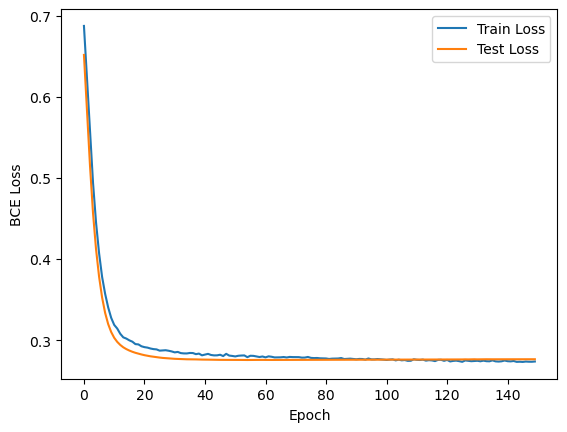

In [ ]:
# Load and split data
X, y = load_data('data/preprocessed_data.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=369, stratify=y)
X_train, X_test = preprocess_data(X_train, X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model, loss, optimizer
model = IncomeRegressor(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
epochs = 150
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Evaluate
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Test Loss: {test_losses[-1]:.4f}")

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

## Evaluating the model

In [40]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)

# Flatten arrays for sklearn
y_true = y_test_tensor.numpy().flatten()
y_pred_label = y_pred_label.flatten()

acc = accuracy_score(y_true, y_pred_label)
prec = precision_score(y_true, y_pred_label)
rec = recall_score(y_true, y_pred_label)
f1 = f1_score(y_true, y_pred_label)
cm = confusion_matrix(y_true, y_pred_label)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.8715
Test Precision: 0.7860
Test Recall: 0.6597
Test F1 Score: 0.7173
Confusion Matrix:
[[4101  257]
 [ 487  944]]


## EXPORTS

In [41]:
torch.save(model.state_dict(), "income_model.pth")

In [49]:
import pickle, joblib

df = pd.read_csv('data/preprocessed_data.csv')
df = df.drop(columns=[col for col in ["capital.gain", "capital.loss"] if col in df.columns])
df.fillna("0.0", inplace=True)
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols.remove("income")
df = pd.get_dummies(df, columns=categorical_cols)
columns = df.drop("income", axis=1).columns.tolist()

# Save columns
with open("columns.pkl", "wb") as f:
    pickle.dump(columns, f)

# Save scaler fitted on the same data
scaler = StandardScaler()
X = df.drop("income", axis=1).values
scaler.fit(X)
joblib.dump(scaler, "scaler.save")

/var/folders/ry/9fdhzbhd61vb1tzt8s482k340000gn/T/ipykernel_84483/1036947330.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("0.0", inplace=True)


['scaler.save']